## **1. Datasets.**

In [2]:
import re
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification

from sklearn.linear_model import LogisticRegression
import numpy as np
from tqdm import tqdm

import sys
import os

# TODO: remove!!!
code_dir = '/Users/elenaericheva/ericheva_git/ccs_aisf/code'
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

print(f"Added {code_dir} to Python path")

Added /Users/elenaericheva/ericheva_git/ccs_aisf/code to Python path


## **2. Choose model.**

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

if torch.backends.mps.is_available():
    torch.mps.empty_cache()
    
# meta-llama/Meta-Llama-3-8B-Instruct - Instruction-tuned (8B parameters)
YOUR_NAME = "Meta-Llama-3-8B-Instruct"
llama_tokenizer = AutoTokenizer.from_pretrained(f"meta-llama/{YOUR_NAME}")
llama_model = AutoModelForCausalLM.from_pretrained(
    f"meta-llama/{YOUR_NAME}",
    torch_dtype=torch.bfloat16,
    device_map="auto",
    low_cpu_mem_usage=True,       
    trust_remote_code=True  
)
llama_model.eval()


/Users/elenaericheva/ericheva_git/ccs_aisf/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

## **3. Get Hidden States. Calculate CCS. Mixed Data**

### **3.1. Get Hidden States. Mixed Data**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from itertools import combinations
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

In [ ]:
# path to big hate data
hate_data = pd.read_csv('../data/raw/total_hate_data.csv', index_col=0)
hate_data.head(2)

hate_total_yes_data = pd.read_csv('../data/yes_no/hate_total_yes_data.csv', index_col=0)
hate_total_no_data =  pd.read_csv('../data/yes_no/hate_total_no_data.csv', index_col=0)

from extract_fixed_llama import vectorize_df, extract_representation

X_pos = vectorize_df(hate_total_yes_data['statement'],
                     llama_model,
                     llama_tokenizer,
                     layer_index=None,
                     strategy="last-token",      # Use last-token for decoder
                     model_type='decoder',       
                     use_decoder=False,          
                     get_all_hs=True,
                     device=None)

X_neg = vectorize_df(hate_total_no_data['statement'],
                     llama_model,
                     llama_tokenizer,
                     layer_index=None,
                     strategy="last-token",      # Use last-token for decoder
                     model_type='decoder',       
                     use_decoder=False,          
                     get_all_hs=True,
                     device=None)

import numpy as np

np.savez_compressed(f'{YOUR_NAME}_neg.npz', X_neg)
np.savez_compressed(f'{YOUR_NAME}_pos.npz', X_pos)

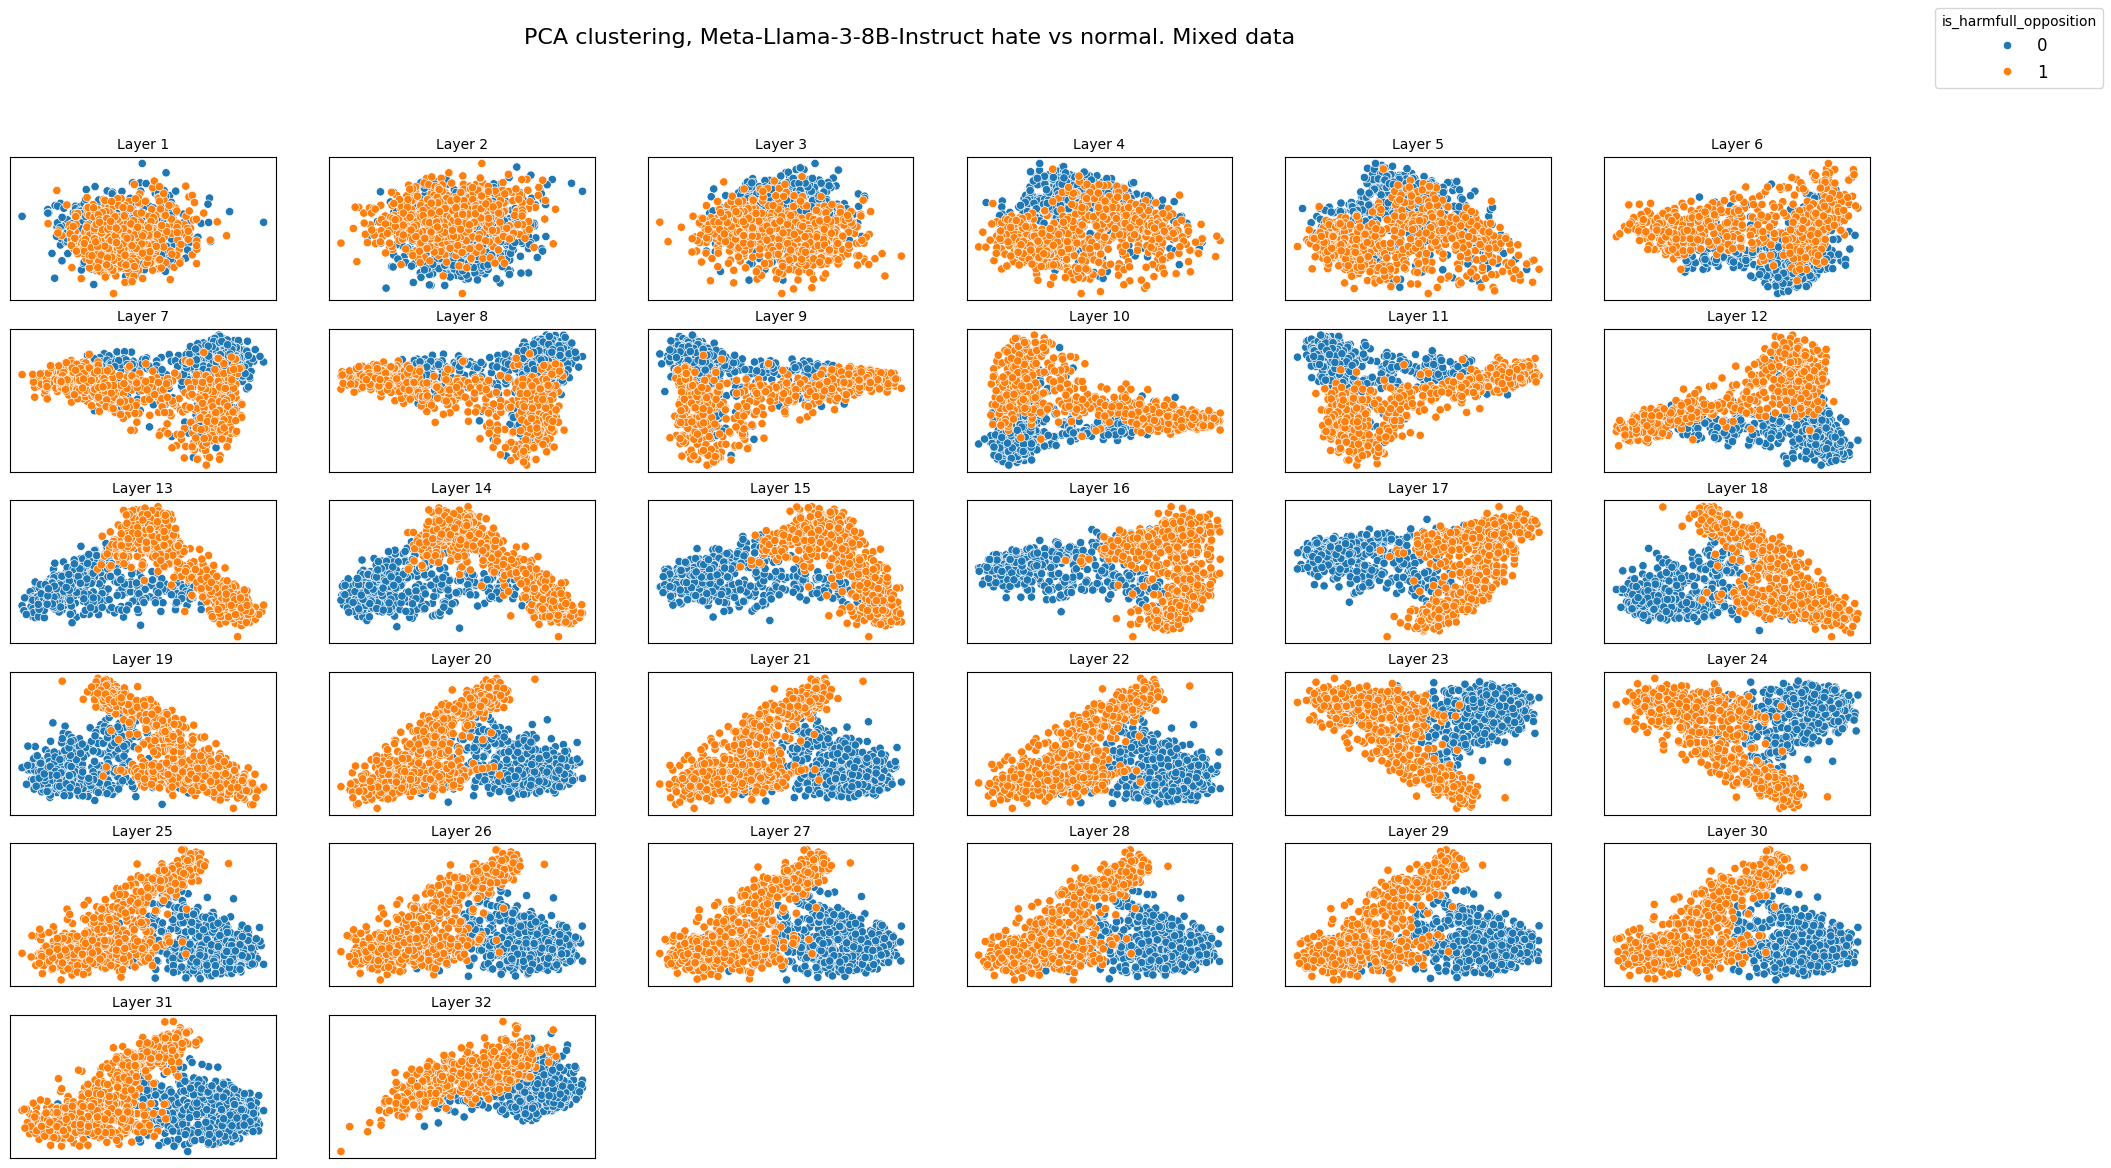

In [9]:
# Load the files correctly
import numpy as np
from sklearn.preprocessing import normalize

hate_data = pd.read_csv('../data/raw/total_hate_data.csv', index_col=0)
YOUR_NAME = "Meta-Llama-3-8B-Instruct"
X_pos_file = np.load(f'{YOUR_NAME}_pos.npz')
X_neg_file = np.load(f'{YOUR_NAME}_neg.npz')

# Extract the actual arrays
X_pos = X_pos_file['arr_0']
X_neg = X_neg_file['arr_0']

# Convert to proper numeric type if needed
X_pos = X_pos.astype(np.float32)
X_neg = X_neg.astype(np.float32)

n_samples, n_layers, n_features = X_pos.shape

# Normalize the data
X_pos_normalized = X_pos.reshape(-1, X_pos.shape[-1])         # (512*25, 768)
X_pos_normalized = normalize(X_pos_normalized, norm='l2', axis=1).reshape(X_pos.shape)

X_neg_normalized = X_neg.reshape(-1, X_neg.shape[-1])         # (512*25, 768)
X_neg_normalized = normalize(X_neg_normalized, norm='l2', axis=1).reshape(X_neg.shape)

# Plot PCA
from format_results_fixed import plot_pca_or_tsne_layerwise
plot_pca_or_tsne_layerwise(X_pos_normalized,
                           X_neg_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title=f'PCA clustering, {YOUR_NAME} hate vs normal. Mixed data')

### **3.2. Find Best CCS. Mixed Data**


To find the best layers, train CCS on all hidden states. You can use different normalization strategies, the best in experiments was l2 + median.

Median normalize used
Layer 1/33, CCS accuracy: 0.5381526104417671
Median normalize used
Layer 2/33, CCS accuracy: 0.5742971887550201
Median normalize used
Layer 3/33, CCS accuracy: 0.6706827309236948
Median normalize used
Layer 4/33, CCS accuracy: 0.6305220883534137
Median normalize used
Layer 5/33, CCS accuracy: 0.6746987951807228
Median normalize used
Layer 6/33, CCS accuracy: 0.678714859437751
Median normalize used
Layer 7/33, CCS accuracy: 0.6746987951807228
Median normalize used
Layer 8/33, CCS accuracy: 0.6746987951807228
Median normalize used
Layer 9/33, CCS accuracy: 0.6626506024096386
Median normalize used
Layer 10/33, CCS accuracy: 0.6666666666666667
Median normalize used
Layer 11/33, CCS accuracy: 0.6586345381526104
Median normalize used
Layer 12/33, CCS accuracy: 0.6666666666666667
Median normalize used
Layer 13/33, CCS accuracy: 0.9116465863453815
Median normalize used
Layer 14/33, CCS accuracy: 0.9357429718875502
Median normalize used
Layer 15/33, CCS accuracy: 0.9518072

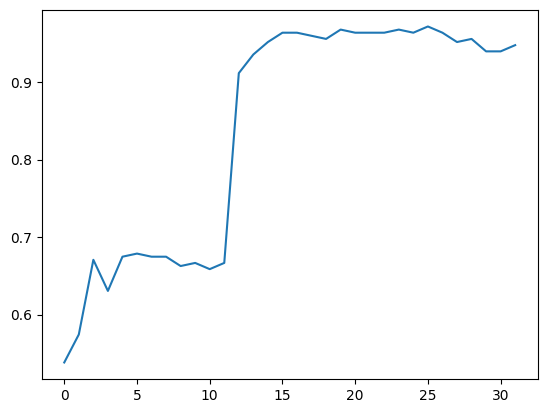

In [5]:
import random
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from ccs import CCS, train_ccs_on_hidden_states



SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Train-test indexes (for all experiments)
idx = np.arange(len(X_pos_normalized))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=71, shuffle=True)


# train CCS on normalized states
orig_ccs = train_ccs_on_hidden_states(X_pos_normalized,
                                        X_neg_normalized,
                                        hate_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')

with open(f'ccs_{YOUR_NAME}_mixed_data_results.pkl', 'wb') as f:
    pickle.dump(orig_ccs, f)

acc = []
for layer_idx in range(llama_model.config.num_hidden_layers):
    acc.append(orig_ccs[layer_idx]['accuracy'])

plt.plot(acc)
plt.show()

LAYER_IDX = np.argmax(acc)


After that, we train the CCS on the selected layer to obtain the probe and its weights.

In [6]:
from ccs import CCS, train_ccs_on_hidden_states
from sklearn.model_selection import train_test_split
import random


X_pos_normalized_data = pd.DataFrame(X_pos_normalized[:, LAYER_IDX])
X_neg_normalized_data = pd.DataFrame(X_neg_normalized[:, LAYER_IDX])

# Train-test indexes (for all experiments)
idx = np.arange(len(X_pos_normalized))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=71, shuffle=True)


# Train-Test indexes
X_pos_norm_train = X_pos_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_pos_norm_test  = X_pos_normalized_data.loc[test_idx, :].values.astype(np.float32)

X_neg_norm_train = X_neg_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_neg_norm_test  = X_neg_normalized_data.loc[test_idx, :].values.astype(np.float32)

y_train = hate_data['is_harmfull_opposition'][train_idx]
y_test  = hate_data['is_harmfull_opposition'][test_idx]

# Median normalizing
X_pos_norm_train -= np.median(X_pos_norm_train)
X_pos_norm_test -= np.median(X_pos_norm_train)

X_neg_norm_train -= np.median(X_neg_norm_train)
X_neg_norm_test -= np.median(X_neg_norm_train)

# Train CCS without labels first NEG, after POS!
ccs = CCS(X_neg_norm_train, X_pos_norm_train, y_train.values, var_normalize=False, lambda_classification=0, predict_normalize=False)
ccs.repeated_train()

# Evaluate
ccs_acc = ccs.get_acc(X_neg_norm_test, X_pos_norm_test, y_test.values)
print("CCS accuracy: {}".format(ccs_acc))

with open(f'ccs_{YOUR_NAME}_l_{LAYER_IDX}_mixed_data_results.pkl', 'wb') as f:
    pickle.dump(ccs, f)

ccs = pickle.load(open(f'ccs_{YOUR_NAME}_l_{LAYER_IDX}_mixed_data_results.pkl', 'rb'))

CCS accuracy: 0.9156626506024097


## **4. Get Hidden States. Calculate CCS. Data with NOT opposition**

### **4.1. Get Hidden States. Data with NOT opposition**

In [ ]:
# path to big hate data
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
hate_data.head(2)

hate_total_yes_data = pd.read_csv('../data/yes_no/hate_total3.0_yes.csv', index_col=0)
hate_total_no_data =  pd.read_csv('../data/yes_no/hate_total3.0_no.csv', index_col=0)



from extract_fixed_llama import vectorize_df, extract_representation

X_pos = vectorize_df(hate_total_yes_data['statement'],
                     llama_model,
                     llama_tokenizer,
                     layer_index=None,
                     strategy="last-token",      # Use last-token for decoder
                     model_type='decoder',       
                     use_decoder=False,          
                     get_all_hs=True,
                     device=None)

X_neg = vectorize_df(hate_total_no_data['statement'],
                     llama_model,
                     llama_tokenizer,
                     layer_index=None,
                     strategy="last-token",      # Use last-token for decoder
                     model_type='decoder',       
                     use_decoder=False,          
                     get_all_hs=True,
                     device=None)

np.savez_compressed(f'{YOUR_NAME}_neg_not.npz', X_neg)
np.savez_compressed(f'{YOUR_NAME}_pos_not.npz', X_pos)



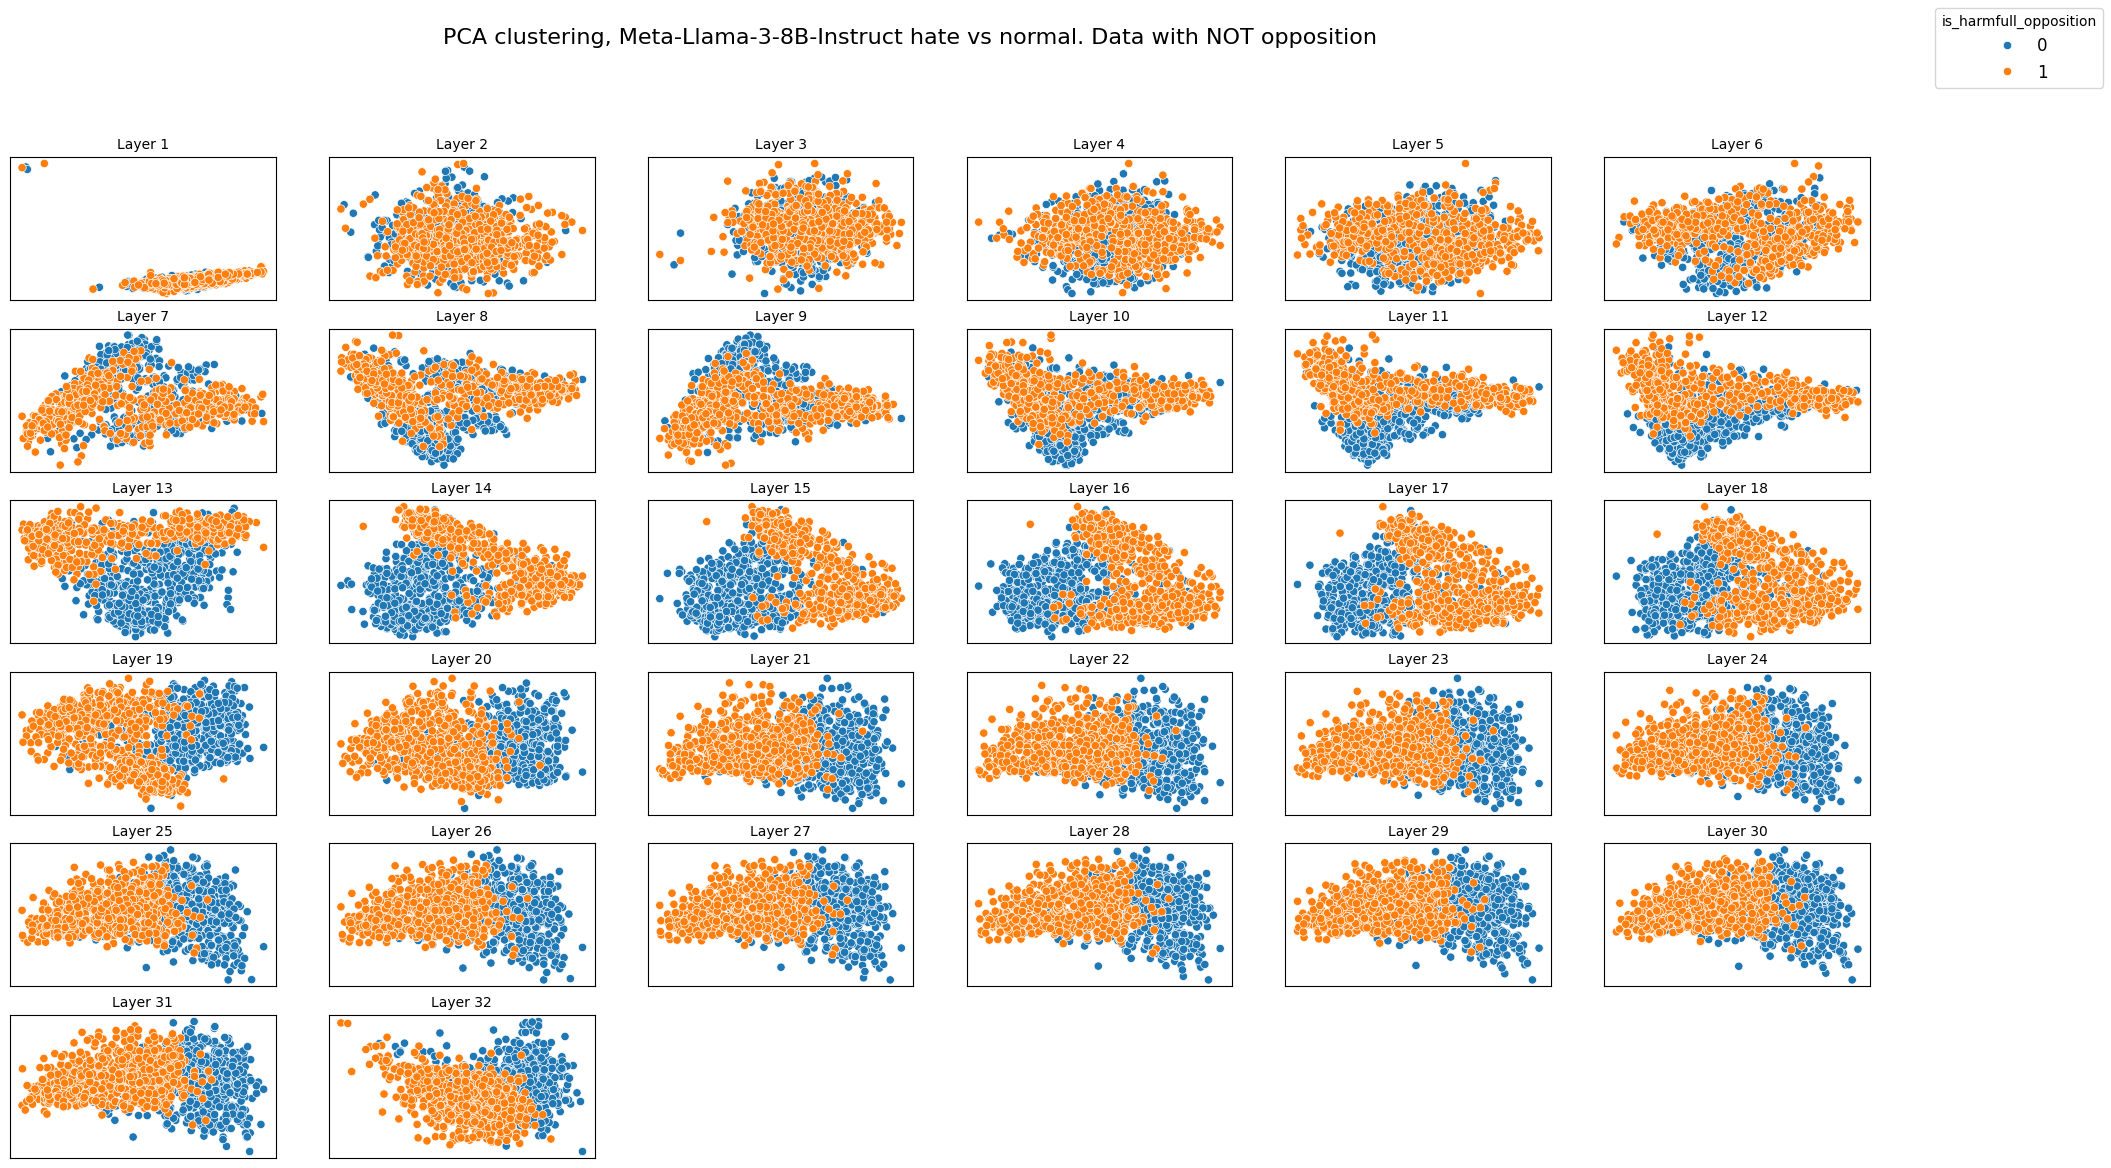

In [10]:
# Load the files correctly
import numpy as np
from sklearn.preprocessing import normalize

hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
YOUR_NAME = "Meta-Llama-3-8B-Instruct"
X_pos_file = np.load(f'{YOUR_NAME}_pos_not.npz')
X_neg_file = np.load(f'{YOUR_NAME}_neg_not.npz')

# Extract the actual arrays
X_pos = X_pos_file['arr_0']
X_neg = X_neg_file['arr_0']

# Convert to proper numeric type if needed
X_pos = X_pos.astype(np.float32)
X_neg = X_neg.astype(np.float32)

n_samples, n_layers, n_features = X_pos.shape

# Normalize the data
X_pos_normalized = X_pos.reshape(-1, X_pos.shape[-1])         # (512*25, 768)
X_pos_normalized = normalize(X_pos_normalized, norm='l2', axis=1).reshape(X_pos.shape)

X_neg_normalized = X_neg.reshape(-1, X_neg.shape[-1])         # (512*25, 768)
X_neg_normalized = normalize(X_neg_normalized, norm='l2', axis=1).reshape(X_neg.shape)

# Plot PCA
from format_results_fixed import plot_pca_or_tsne_layerwise
plot_pca_or_tsne_layerwise(X_pos_normalized,
                           X_neg_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title=f'PCA clustering, {YOUR_NAME} hate vs normal. Data with NOT opposition')

### **4.2. Find Best CCS. Data with NOT opposition**

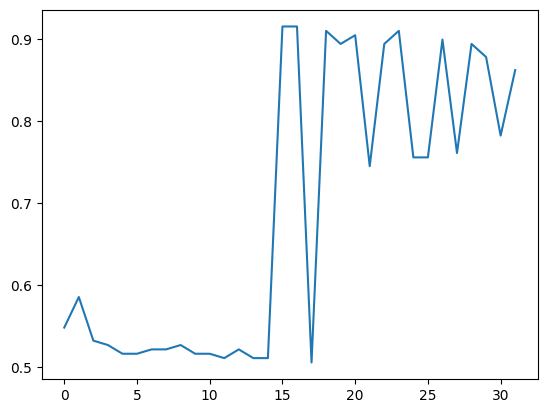

In [ ]:
from ccs import CCS, train_ccs_on_hidden_states
from sklearn.model_selection import train_test_split
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Train-test indexes (for all experiments)
idx = np.arange(len(X_pos_normalized))
train_idx, test_idx = train_test_split(idx, test_size=0.15, random_state=71, shuffle=True)


# train CCS on normalized states
orig_ccs = train_ccs_on_hidden_states(X_pos_normalized,
                                        X_neg_normalized,
                                        hate_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')
with open(f'ccs_{YOUR_NAME}_not_data_results.pkl', 'wb') as f:
    pickle.dump(orig_ccs, f)

acc = []
for layer_idx in range(llama_model.config.num_hidden_layers):
    acc.append(orig_ccs[layer_idx]['accuracy'])

plt.plot(acc)
plt.show()

LAYER_IDX = np.argmax(acc)


In [9]:
from ccs import CCS
import random

X_pos_normalized_data = pd.DataFrame(X_pos_normalized[:, LAYER_IDX])
X_neg_normalized_data = pd.DataFrame(X_neg_normalized[:, LAYER_IDX])


# Train-Test indexes
X_pos_norm_train = X_pos_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_pos_norm_test  = X_pos_normalized_data.loc[test_idx, :].values.astype(np.float32)

X_neg_norm_train = X_neg_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_neg_norm_test  = X_neg_normalized_data.loc[test_idx, :].values.astype(np.float32)

y_train = hate_data['is_harmfull_opposition'][train_idx]
y_test  = hate_data['is_harmfull_opposition'][test_idx]

# Median normalizing
X_pos_norm_train -= np.median(X_pos_norm_train)
X_pos_norm_test -= np.median(X_pos_norm_train)

X_neg_norm_train -= np.median(X_neg_norm_train)
X_neg_norm_test -= np.median(X_neg_norm_train)

# Train CCS without labels first NEG, after POS!
ccs = CCS(X_neg_norm_train, X_pos_norm_train, y_train.values, var_normalize=False, lambda_classification=0, predict_normalize=False)
ccs.repeated_train()

# Evaluate
ccs_acc = ccs.get_acc(X_neg_norm_test, X_pos_norm_test, y_test.values)
print("CCS accuracy: {}".format(ccs_acc))

CCS accuracy: 0.7606382978723404


## **5. Get Hidden States. Calculate CCS. Data with TTT mask**

### **5.1 Get Hidden States. Data with TTT mask**

In [ ]:
# path to big hate data
# path to big hate data
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
hate_data.head(2)

hate_total_yes_data = pd.read_csv('../data/yes_no/hate_total3.0_yes.csv', index_col=0)
hate_total_no_data =  pd.read_csv('../data/yes_no/hate_total3.0_no.csv', index_col=0)

hate_total_yes_data['statement'] = hate_total_yes_data['statement'].apply(
                                    lambda x: x.replace('not', 'ttt').replace('Not', 'ttt'))
hate_total_no_data['statement'] = hate_total_no_data['statement'].apply(
                                        lambda x: x.replace('not', 'ttt').replace('Not', 'ttt'))


from extract_fixed_llama import vectorize_df, extract_representation

X_pos = vectorize_df(hate_total_yes_data['statement'],
                     llama_model,
                     llama_tokenizer,
                     layer_index=None,
                     strategy="last-token",      # CHANGED: Use last-token for decoder
                     model_type='decoder',       # CHANGED: Gemma is decoder, not encoder
                     use_decoder=False,          # CHANGED: Not needed for decoder-only
                     get_all_hs=True,
                     device=None)

X_neg = vectorize_df(hate_total_no_data['statement'],
                     llama_model,
                     llama_tokenizer,
                     layer_index=None,
                     strategy="last-token",      # CHANGED: Use last-token for decoder
                     model_type='decoder',       # CHANGED: Gemma is decoder, not encoder
                     use_decoder=False,          # CHANGED: Not needed for decoder-only
                     get_all_hs=True,
                     device=None)

np.savez_compressed(f'{YOUR_NAME}_neg_ttt.npz', X_neg)
np.savez_compressed(f'{YOUR_NAME}_pos_ttt.npz', X_pos)



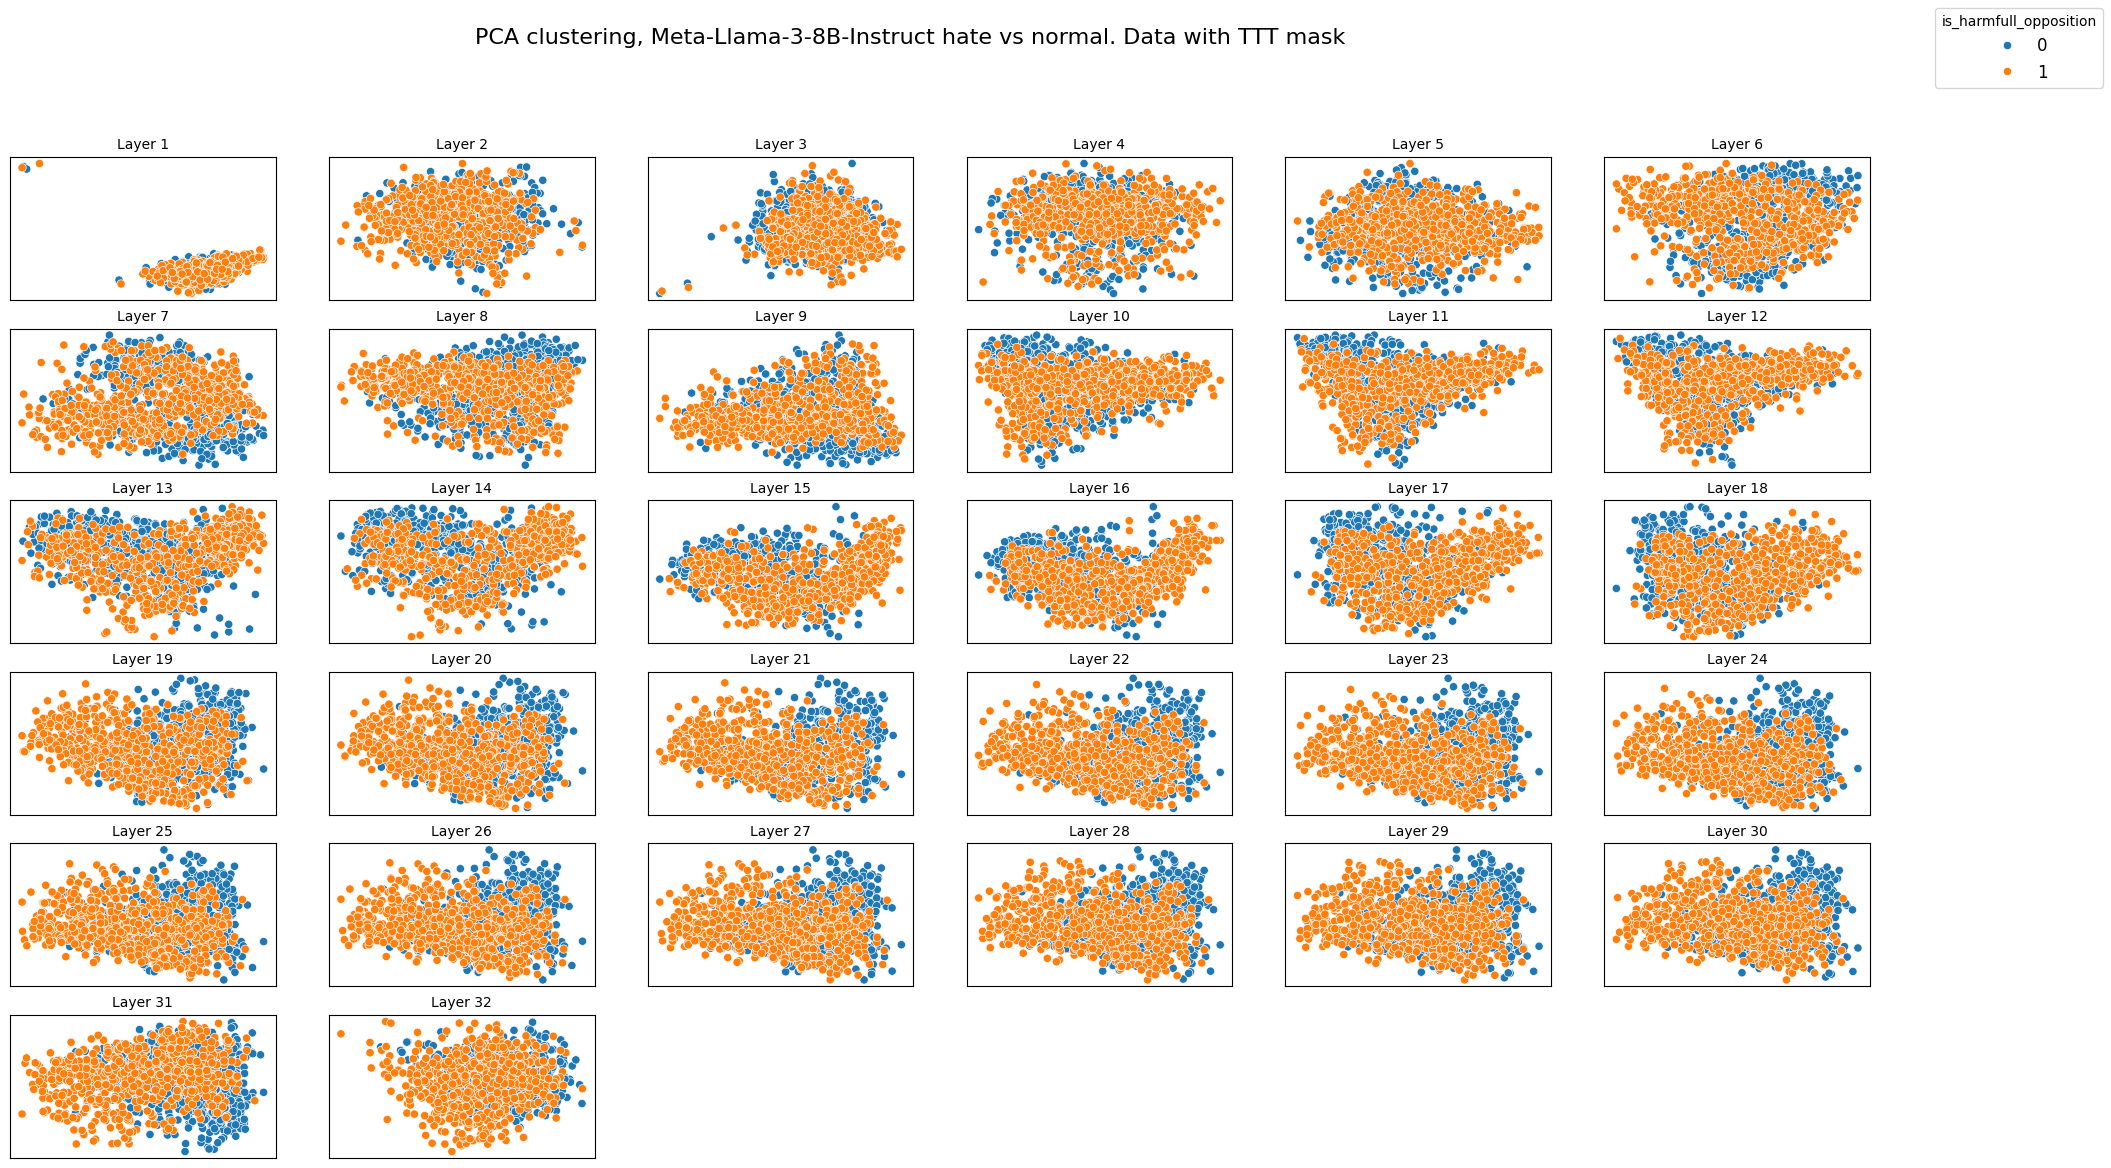

In [15]:
# Load the files correctly
import numpy as np
from sklearn.preprocessing import normalize

hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
YOUR_NAME = "Meta-Llama-3-8B-Instruct"
X_pos_file = np.load(f'{YOUR_NAME}_pos_ttt.npz')
X_neg_file = np.load(f'{YOUR_NAME}_neg_ttt.npz')

# Extract the actual arrays
X_pos = X_pos_file['arr_0']
X_neg = X_neg_file['arr_0']

# Convert to proper numeric type if needed
X_pos = X_pos.astype(np.float32)
X_neg = X_neg.astype(np.float32)

n_samples, n_layers, n_features = X_pos.shape

# Normalize the data
X_pos_normalized = X_pos.reshape(-1, X_pos.shape[-1])         # (512*25, 768)
X_pos_normalized = normalize(X_pos_normalized, norm='l2', axis=1).reshape(X_pos.shape)

X_neg_normalized = X_neg.reshape(-1, X_neg.shape[-1])         # (512*25, 768)
X_neg_normalized = normalize(X_neg_normalized, norm='l2', axis=1).reshape(X_neg.shape)

# Plot PCA
from format_results_fixed import plot_pca_or_tsne_layerwise
plot_pca_or_tsne_layerwise(X_pos_normalized,
                           X_neg_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title=f'PCA clustering, {YOUR_NAME} hate vs normal. Data with TTT mask')

### **5.2 Find best CCS. Data with TTT mask**

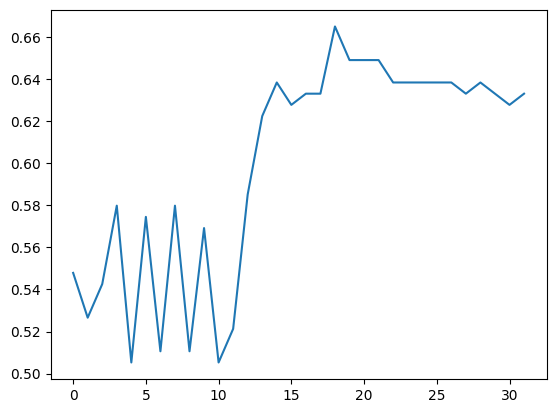

In [ ]:
from ccs import CCS, train_ccs_on_hidden_states
from sklearn.model_selection import train_test_split
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Train-test indexes (for all experiments)
idx = np.arange(len(X_pos_normalized))
train_idx, test_idx = train_test_split(idx, test_size=0.15, random_state=71, shuffle=True)


# train CCS on normalized states
orig_ccs = train_ccs_on_hidden_states(X_pos_normalized,
                                        X_neg_normalized,
                                        hate_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')
with open(f'ccs_{YOUR_NAME}_ttt_data_results.pkl', 'wb') as f:
    pickle.dump(orig_ccs, f)

acc = []
for layer_idx in range(llama_model.config.num_hidden_layers):
    acc.append(orig_ccs[layer_idx]['accuracy'])

plt.plot(acc)
plt.show()

LAYER_IDX = np.argmax(acc)


In [12]:
from ccs import CCS
import random

X_pos_normalized_data = pd.DataFrame(X_pos_normalized[:, LAYER_IDX])
X_neg_normalized_data = pd.DataFrame(X_neg_normalized[:, LAYER_IDX])


# Train-Test indexes
X_pos_norm_train = X_pos_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_pos_norm_test  = X_pos_normalized_data.loc[test_idx, :].values.astype(np.float32)

X_neg_norm_train = X_neg_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_neg_norm_test  = X_neg_normalized_data.loc[test_idx, :].values.astype(np.float32)

y_train = hate_data['is_harmfull_opposition'][train_idx]
y_test  = hate_data['is_harmfull_opposition'][test_idx]

# Median normalizing
X_pos_norm_train -= np.median(X_pos_norm_train)
X_pos_norm_test -= np.median(X_pos_norm_train)

X_neg_norm_train -= np.median(X_neg_norm_train)
X_neg_norm_test -= np.median(X_neg_norm_train)

# Train CCS without labels first NEG, after POS!
ccs = CCS(X_neg_norm_train, X_pos_norm_train, y_train.values, var_normalize=False, lambda_classification=0, predict_normalize=False)
ccs.repeated_train()

# Evaluate
ccs_acc = ccs.get_acc(X_neg_norm_test, X_pos_norm_test, y_test.values)
print("CCS accuracy: {}".format(ccs_acc))

CCS accuracy: 0.601063829787234


## **7. Plot results tables.**

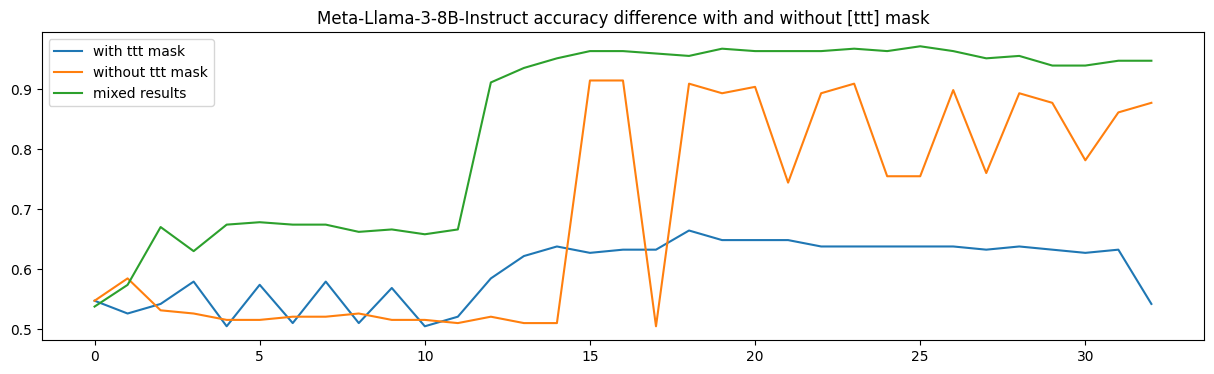

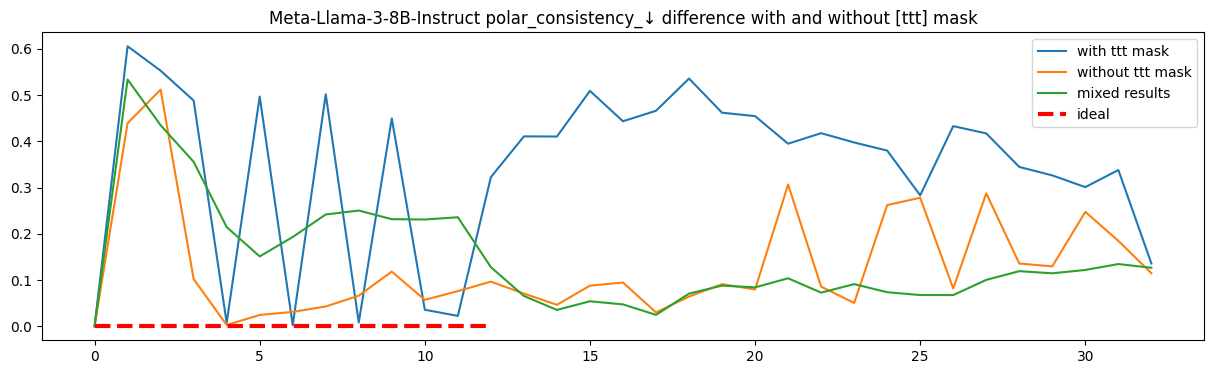

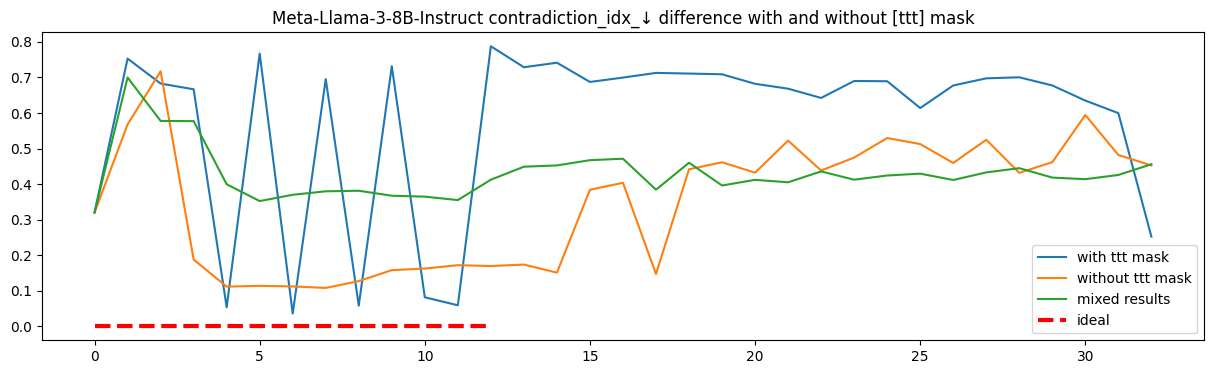

In [3]:
from format_results_fixed import get_results_table
import pickle
import matplotlib.pyplot as plt

YOUR_NAME = "Meta-Llama-3-8B-Instruct"
metrics = ['accuracy', 'polar_consistency_↓', 
       'contradiction_idx_↓']

with open(f'ccs_{YOUR_NAME}_ttt_data_results.pkl', 'rb') as f:
  enc_base_ttt = pickle.load(f)

with open(f'ccs_{YOUR_NAME}_not_data_results.pkl', 'rb') as f:
    enc_base = pickle.load(f)

with open(f'ccs_{YOUR_NAME}_mixed_data_results.pkl', 'rb') as f:
   enc_base_orig = pickle.load(f)

enc_base_ttt_table = get_results_table(enc_base_ttt)
enc_base_table = get_results_table(enc_base)
enc_base_orig_table = get_results_table(enc_base_orig)

for idx, metric in enumerate(metrics):
    fig = plt.figure(figsize=(15, 4))
    plt.plot(enc_base_ttt_table[metric], label='with ttt mask')
    plt.plot(enc_base_table[metric], label='without ttt mask')
    plt.plot(enc_base_orig_table[metric], label='mixed results')
    
    if idx != 0:
        plt.hlines(0, 0, 12, label='ideal', colors='red', linewidth=3, linestyles='--')
    plt.legend()
    plt.title(f'{YOUR_NAME} {metric} difference with and without [ttt] mask')
    plt.show()